In [29]:
import sys
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(src_path)

from tools.helpers import (
    create_ohlc_dataframe,
    extract_bid_ask_spread,
    get_close_price,
    get_executed_volume,
)
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict

from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import scienceplots


plt.style.use("science")

In [17]:
with open('/home/figal/Projects/cuba_fx_market/data/analytics/lob_data.pickle', 'rb') as file:
    lob_data = pickle.load(file)

In [18]:
close_prices = get_close_price(lob_data, "2021-07-23", "2025-01-15")

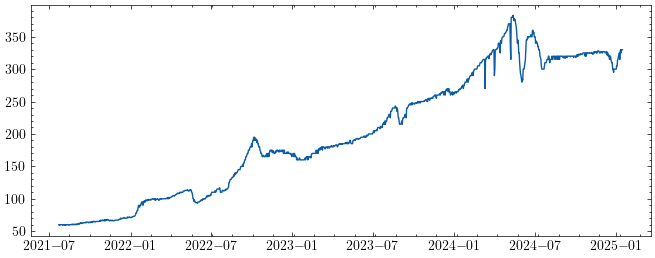

In [19]:
plt.figure(figsize=(8,3))
plt.plot(close_prices)
plt.show()

In [20]:
executed_volume = get_executed_volume(lob_data, "2021-08-01", "2024-11-14", flag=False)

dates = []
num_executions = []
total_orders = []

for date, info in lob_data.items():

    dates.append(date)
    num_executions.append(len(info.executed_orders))
    total_orders.append(
        len(info.executed_orders)
        + len(info.limit_orders_buy)
        + len(info.limit_orders_sell)
    )

df = pd.DataFrame(
    {"date": dates, "num_executions": num_executions, "total_orders": total_orders}
)
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

executions_percent = df["num_executions"].values / df["total_orders"].values

groupy_executed_volume = executed_volume.groupby(executed_volume.index).sum()

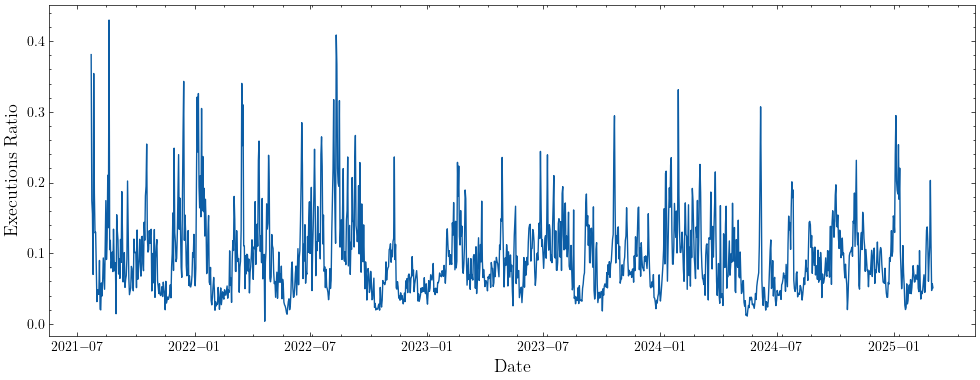

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(df.index[:-1], executions_percent[:-1])
plt.xlabel('Date', fontsize=13)
plt.ylabel('Executions Ratio', fontsize=13)
plt.tick_params(axis='both', labelsize=10)
plt.tight_layout()
plt.show()

In [22]:
bid_profile = {}
ask_profile = {}

for date, info in lob_data.items():
    if info.limit_orders_buy and info.limit_orders_sell:
        best_bid_price = info.limit_orders_buy[0].price
        best_ask_price = info.limit_orders_sell[0].price
        
        result_bid = [
            (order.volume, round(abs(order.price - best_bid_price) / best_bid_price, 2)) for order in info.limit_orders_buy
        ]
        result_ask = [
            (order.volume, round(abs(order.price - best_ask_price) / best_ask_price, 2)) for order in info.limit_orders_sell
        ]
        
        aggregated_bid = defaultdict(float)
        for volume, relative_distance in result_bid:
            aggregated_bid[relative_distance] += volume
            
        aggregated_ask = defaultdict(float)
        for volume, relative_distance in result_ask:
            aggregated_ask[relative_distance] += volume

        bid_profile[date] = list(aggregated_bid.items())
        ask_profile[date] = list(aggregated_ask.items())

bid_flattened_data = [item for sublist in list(bid_profile.values()) for item in sublist]
ask_flattened_data = [item for sublist in list(ask_profile.values()) for item in sublist]

bid_aggregated_data = defaultdict(float)
for key, value in bid_flattened_data:
    bid_aggregated_data[key] += value
bid_result = list(bid_aggregated_data.items())
bid_sorted_data = sorted(bid_result)

ask_aggregated_data = defaultdict(float)
for key, value in ask_flattened_data:
    ask_aggregated_data[key] += value
ask_result = list(ask_aggregated_data.items())
ask_sorted_data = sorted(ask_result)

In [23]:
x_bid = []
y_bid = []
for i in bid_sorted_data:
    x_bid.append(i[0])
    y_bid.append(i[1])
    
x_ask = []
y_ask = []
for i in ask_sorted_data:
    x_ask.append(i[0])
    y_ask.append(i[1])

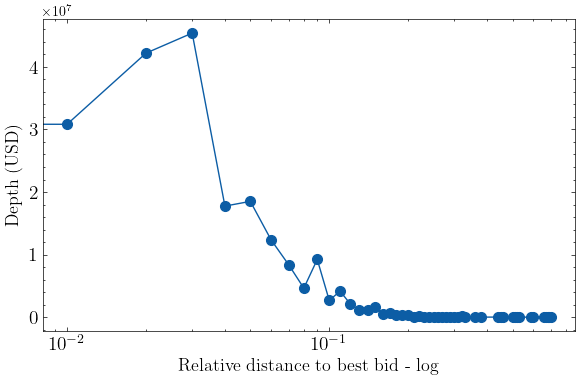

In [24]:
plt.figure(figsize=(6,4))
plt.plot(x_bid, y_bid, "o-", markersize=7)
# plt.plot(x_ask, y_ask, "^-", color='orange')
plt.ylabel("Depth (USD)", fontsize=13)
plt.xlabel("Relative distance to best bid - log", fontsize=13)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
# plt.yscale('log')
plt.xscale('log')
#plt.ylim(0*10**7,0.2*10**5)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

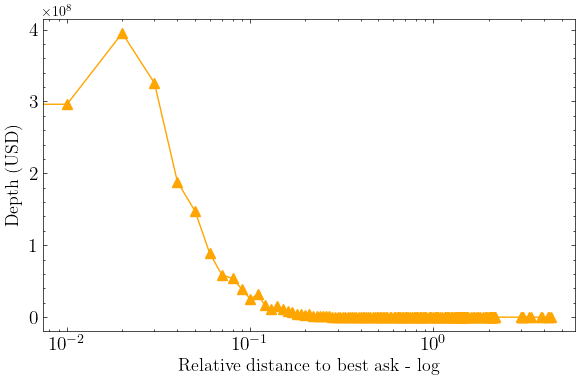

In [25]:
plt.figure(figsize=(6,4))
plt.plot(x_ask, y_ask, "^-", color='orange', markersize=7)
plt.ylabel("Depth (USD)", fontsize=13)
plt.xlabel("Relative distance to best ask - log", fontsize=13)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
plt.tick_params(axis='both', labelsize=10)
plt.xscale('log')
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

In [26]:
market_orders_size_usd = {}

for date, info in lob_data.items():
    mo_size = sum([mo.volume for mo in info.market_orders_sell]) + sum([mo.volume for mo in info.market_orders_buy])
    try:
        market_orders_size_usd[date] = mo_size
    except:
        pass

sizes = list(market_orders_size_usd.values())

sorted_sizes = np.sort(sizes)

cumulative_probabilities = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)

In [30]:
def exponential_func(x, a, b):
    return a * np.exp(-b * x)

params, covariance = curve_fit(exponential_func, sorted_sizes, 1 - cumulative_probabilities, p0=[1, 1e-6])

a_fit, b_fit = params
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")

fitted_values = exponential_func(sorted_sizes, a_fit, b_fit)

Fitted parameters: a = 1.265460583880634, b = 8.981073702511646e-05


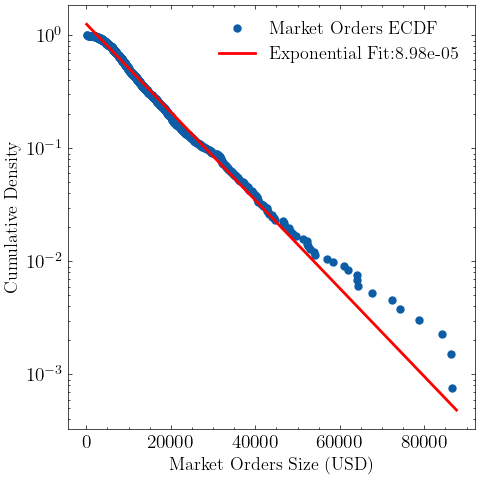

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(sorted_sizes, 1 - cumulative_probabilities, marker='.', linestyle='none', label="Market Orders ECDF", markersize=10)
ax.plot(sorted_sizes, fitted_values, 'r-', label=f"Exponential Fit:{b_fit:.2e}", linewidth=2)
ax.set_xlabel("Market Orders Size (USD)", fontsize=13)
ax.set_ylabel("Cumulative Density", fontsize=13)
ax.set_yscale("log")
# ax.set_xscale("log")
plt.legend(fontsize=13)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

In [32]:
limit_orders_size_usd = {}

for date, info in lob_data.items():
    lo_size = sum([lo.volume for lo in info.limit_orders_buy]) + sum([lo.volume for lo in info.limit_orders_sell])
    try:
        limit_orders_size_usd[date] = lo_size
    except:
        pass

sizes = list(limit_orders_size_usd.values())

sorted_sizes = np.sort(sizes)

cumulative_probabilities = np.arange(1, len(sorted_sizes) + 1) / len(sorted_sizes)

In [33]:
def exponential_func(x, a, b):
    return a * np.exp(-b * x)

params, covariance = curve_fit(exponential_func, sorted_sizes, 1 - cumulative_probabilities, p0=[1, 1e-6])

a_fit, b_fit = params
print(f"Fitted parameters: a = {a_fit}, b = {b_fit}")

fitted_values = exponential_func(sorted_sizes, a_fit, b_fit)

Fitted parameters: a = 1.6050835398039862, b = 8.648378059506963e-07


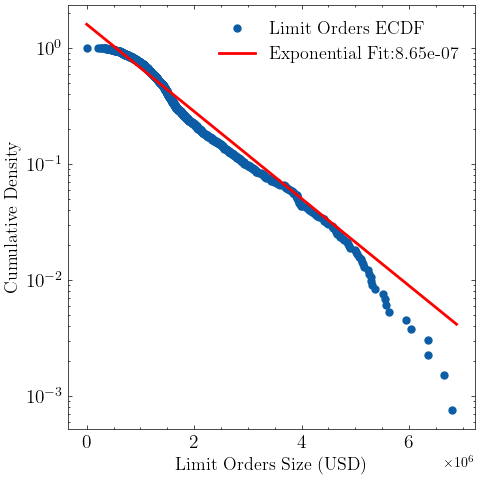

In [35]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(sorted_sizes, 1 - cumulative_probabilities, marker='.', linestyle='none', label="Limit Orders ECDF", markersize=10)
ax.plot(sorted_sizes, fitted_values, 'r-', label=f"Exponential Fit:{b_fit:.2e}", linewidth=2)
ax.set_xlabel("Limit Orders Size (USD)", fontsize=13)
ax.set_ylabel("Cumulative Density", fontsize=13)
ax.set_yscale("log")
# ax.set_xscale("log")
plt.legend(fontsize=13)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.show()

In [36]:
bid_ask_spread = extract_bid_ask_spread(lob_data, "2021-07-23", "2024-11-14", flag=True)

relative_bid_ask_spread = bid_ask_spread / close_prices["prices"]
relative_bid_ask_spread.dropna(inplace=True)

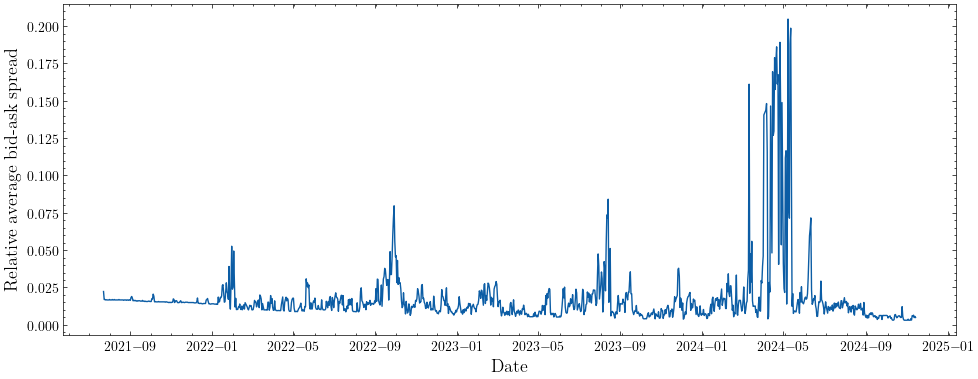

In [38]:
plt.figure(figsize=(10, 4))
plt.plot(relative_bid_ask_spread)
plt.xlabel('Date', fontsize=13)  
plt.ylabel("Relative average bid-ask spread", fontsize=13)
plt.tick_params(axis='both', labelsize=10)
plt.tight_layout()
plt.show()

In [39]:
bid_profile = {}
ask_profile = {}

for date, info in lob_data.items():
    try:
        best_bid = max(p.price for p in info.limit_orders_buy)
        best_ask = min(p.price for p in info.limit_orders_sell)

        distance_bid = np.mean([best_bid - p.price for p in info.limit_orders_buy])
        distance_ask = np.mean([p.price - best_ask for p in info.limit_orders_sell])

        bid_profile[date] = distance_bid / best_bid
        ask_profile[date] = distance_ask / best_ask
    except ValueError:
        # print(f"No hay órdenes disponibles para la fecha: {date}")
        bid_profile[date] = None
        ask_profile[date] = None
bid_profile = pd.DataFrame.from_dict(
    bid_profile, orient="index", columns=["bid_profile"]
)
ask_profile = pd.DataFrame.from_dict(
    ask_profile, orient="index", columns=["ask_profile"]
)
bid_profile.index = pd.to_datetime(bid_profile.index)
ask_profile.index = pd.to_datetime(ask_profile.index)

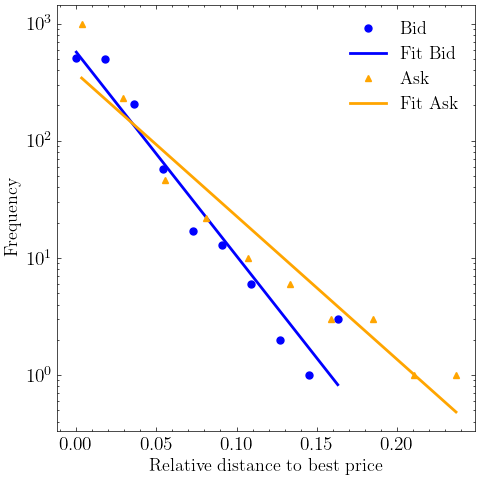

In [40]:
hist_buy, bins_buy = np.histogram(bid_profile["bid_profile"].dropna().values, bins=10)

def linear_f(x, a, b):
    return a + b * x

popt_buy, pcov_buy = curve_fit(linear_f, bins_buy[:-1], np.log(hist_buy))
exp_fit_buy = lambda x: np.exp(popt_buy[0]) * np.exp(popt_buy[1] * x)
xs_buy = np.linspace(min(bins_buy[:-1]), max(bins_buy[:-1]), 100)

hist_sell, bins_sell = np.histogram(ask_profile["ask_profile"].dropna().values, bins=10)

popt_sell, pcov_sell = curve_fit(linear_f, bins_sell[:-1], np.log(hist_sell))
exp_fit_sell = lambda x: np.exp(popt_sell[0]) * np.exp(popt_sell[1] * x)
xs_sell = np.linspace(min(bins_sell[:-1]), max(bins_sell[:-1]), 100)

fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(bins_buy[:-1], hist_buy, "o", label="Bid", color='blue', markersize=5, linewidth=2.0)
ax.plot(xs_buy, [exp_fit_buy(i) for i in xs_buy], label="Fit Bid", color='blue', linewidth=2.0)

ax.plot(bins_sell[:-1], hist_sell, "^", label="Ask", color='orange', markersize=5, linewidth=2.0)
ax.plot(xs_sell, [exp_fit_sell(i) for i in xs_sell], label="Fit Ask", color='orange', linewidth=2.0)

ax.set_xlabel("Relative distance to best price", fontsize=13)
ax.set_ylabel("Frequency", fontsize=13)
ax.set_yscale("log")
plt.legend(fontsize=13)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()

plt.show()